In [22]:
!poetry add requests bs4 google-search-results lxml transformers torch datasets pymilvus pillow

The following packages are already present in the pyproject.toml and will be skipped:

  - requests
  - bs4
  - google-search-results
  - lxml
  - transformers
  - torch
  - datasets
  - pymilvus

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Using version ^10.3.0 for pillow

Updating dependencies
Resolving dependencies... (0.6s)

Package operations: 1 install, 0 updates, 0 removals

  - Installing pillow (10.3.0): Pending...
  - Installing pillow (10.3.0): Installing...
  - Installing pillow (10.3.0)

Writing lock file


In [1]:
import requests, lxml, re, json, urllib.request
from bs4 import BeautifulSoup

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.114 Safari/537.36"
}

params = {
    "q": "lord of the rings film scenes", # search query
    "tbm": "isch",                # image results
    "hl": "en",                   # language of the search
    "gl": "us",                   # country where search comes from
    "ijn": "0"                    # page number
}

html = requests.get("https://www.google.com/search", params=params, headers=headers, timeout=30)
soup = BeautifulSoup(html.text, "lxml")

def get_images_with_request_headers():
    del params["ijn"]
    params["content-type"] = "image/png" # parameter that indicate the original media type

    return [img["src"] for img in soup.select("img")]

def get_suggested_search_data():
    suggested_searches = []

    all_script_tags = soup.select("script")

    # https://regex101.com/r/48UZhY/6
    matched_images = "".join(re.findall(r"AF_initDataCallback\(({key: 'ds:1'.*?)\);</script>", str(all_script_tags)))

    # https://kodlogs.com/34776/json-decoder-jsondecodeerror-expecting-property-name-enclosed-in-double-quotes
    # if you try to json.loads() without json.dumps it will throw an error:
    # "Expecting property name enclosed in double quotes"
    matched_images_data_fix = json.dumps(matched_images)
    matched_images_data_json = json.loads(matched_images_data_fix)

    # search for only suggested search thumbnails related
    # https://regex101.com/r/ITluak/2
    suggested_search_thumbnails = ",".join(re.findall(r'{key(.*?)\[null,\"Size\"', matched_images_data_json))

    # https://regex101.com/r/MyNLUk/1
    suggested_search_thumbnail_encoded = re.findall(r'\"(https:\/\/encrypted.*?)\"', suggested_search_thumbnails)

    for suggested_search, suggested_search_fixed_thumbnail in zip(soup.select(".PKhmud.sc-it.tzVsfd"), suggested_search_thumbnail_encoded):
        suggested_searches.append({
            "name": suggested_search.select_one(".VlHyHc").text,
            "link": f"https://www.google.com{suggested_search.a['href']}",
            # https://regex101.com/r/y51ZoC/1
            "chips": "".join(re.findall(r"&chips=(.*?)&", suggested_search.a["href"])),
            # https://stackoverflow.com/a/4004439/15164646 comment by Frédéric Hamidi
            "thumbnail": bytes(suggested_search_fixed_thumbnail, "ascii").decode("unicode-escape")
        })

    return suggested_searches

def get_original_images():

    """
    https://kodlogs.com/34776/json-decoder-jsondecodeerror-expecting-property-name-enclosed-in-double-quotes
    if you try to json.loads() without json.dumps() it will throw an error:
    "Expecting property name enclosed in double quotes"
    """

    google_images = []

    all_script_tags = soup.select("script")

    # # https://regex101.com/r/48UZhY/4
    matched_images_data = "".join(re.findall(r"AF_initDataCallback\(([^<]+)\);", str(all_script_tags)))

    matched_images_data_fix = json.dumps(matched_images_data)
    matched_images_data_json = json.loads(matched_images_data_fix)

    # https://regex101.com/r/VPz7f2/1
    matched_google_image_data = re.findall(r'\"b-GRID_STATE0\"(.*)sideChannel:\s?{}}', matched_images_data_json)

    # https://regex101.com/r/NnRg27/1
    matched_google_images_thumbnails = ", ".join(
        re.findall(r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]',
                   str(matched_google_image_data))).split(", ")

    thumbnails = [
        bytes(bytes(thumbnail, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for thumbnail in matched_google_images_thumbnails
    ]

    # removing previously matched thumbnails for easier full resolution image matches.
    removed_matched_google_images_thumbnails = re.sub(
        r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]', "", str(matched_google_image_data))

    # https://regex101.com/r/fXjfb1/4
    # https://stackoverflow.com/a/19821774/15164646
    matched_google_full_resolution_images = re.findall(r"(?:'|,),\[\"(https:|http.*?)\",\d+,\d+\]", removed_matched_google_images_thumbnails)

    full_res_images = [
        bytes(bytes(img, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for img in matched_google_full_resolution_images
    ]

    return full_res_images

In [2]:
list_image_urls = get_original_images()

In [16]:
list_image_urls

[]

In [22]:
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from datasets import load_dataset
import torch
from PIL import Image

In [4]:
image_data = load_dataset("conceptual_captions", split="train")

/Users/stephen/Library/Caches/pypoetry/virtualenvs/multimodal-milvus-clip-SwowcNo4-py3.11/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for conceptual_captions contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conceptual_captions
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [27]:
def get_image():
   # response = requests.get(image_URL)
   image = Image.open('images/retriever-smiling-cropped.jpg').convert("RGB")
   return image

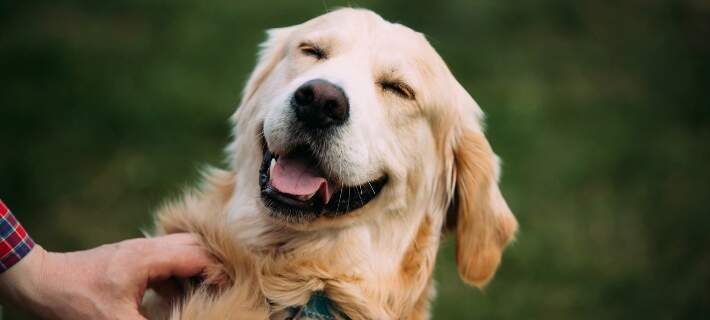

In [28]:
one_image = get_image()
one_image

In [6]:
def get_model_info(model_ID, device):
	# Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
	# Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
  # Return model, processor & tokenizer
	return model, processor, tokenizer

In [7]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

/Users/stephen/Library/Caches/pypoetry/virtualenvs/multimodal-milvus-clip-SwowcNo4-py3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
model, processor, tokenizer

In [9]:
def get_single_image_embedding(my_image,processor, model, device):
  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
      )["pixel_values"].to(device)
  embedding = model.get_image_features(image)
  # convert the embeddings to numpy array
  return embedding.cpu().detach().numpy()

In [29]:
one_vector = get_single_image_embedding(one_image, processor, model, device) # Simple test

In [32]:
from PIL import Image
import os

def get_all_image_embeddings_from_folder(processor, model, device, num_images=100):
    embeddings = []
    working_paths = []

    # Path to the image folder
    folder_path = 'Images'

    # List all files in the directory and filter out non-image files
    all_files = os.listdir(folder_path)
    image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Limit the number of images to process if necessary
    image_files = image_files[:num_images]

    for image_file in image_files:
        full_path = os.path.join(folder_path, image_file)
        try:
            # Load the image directly from the folder
            image = Image.open(full_path).convert("RGB")

            # Get the embedding for the image
            embedding = get_single_image_embedding(image, processor, model, device)
            embeddings.append(embedding)
            working_paths.append(full_path)
        except Exception as e:
            print(f"Error processing image from {full_path}: {e}")

    return embeddings, working_paths

# Example usage
embeddings, working_images = get_all_image_embeddings_from_folder(processor, model, device)


In [34]:
embeddings, working_images = get_all_image_embeddings_from_folder(processor, model, device)

In [37]:
assert len(embeddings) == len(working_images)

In [40]:
working_images

['Images/retriever-smiling-cropped.jpg',
 'Images/SurfSurf.jpeg',
 'Images/DSC0392-e1504532344241.jpg',
 'Images/usa-hawaii-surfer-welle.jpg',
 'Images/Untitled-design-43-800x800.jpg']

# Insert data into Milvus

In [36]:
from pymilvus import MilvusClient

In [49]:
client = MilvusClient()

collection_name = "multimodal_search"
vector_dim = embeddings[0].shape[1]
vector_dim

512

In [61]:
client.create_collection(collection_name=collection_name, dimension=vector_dim)

In [54]:
def create_data_to_upsert(dataset,  embeddings, num_images):
    metadata = []
    image_IDs = []
    for index in range(len(dataset)):
    metadata.append({
        'id': index,
        'vector': dataset[index]#['image_url']
    })
    image_IDs.append(str(index))
    image_embeddings = [arr.tolist() for arr in embeddings]
    data_to_upsert = list(zip(image_IDs, image_embeddings, metadata))
    return data_to_upsert

In [56]:
data_to_upsert = create_data_to_upsert(working_images, embeddings, len(working_images))

In [65]:
client.upsert(data=data_to_upsert, collection_name=collection_name)

RPC error: [upsert_rows], <DataNotMatchException: (code=1, message=The Input data type is inconsistent with defined schema, please check it.)>, <Time:{'RPC start': '2024-05-06 18:21:22.941116', 'RPC error': '2024-05-06 18:21:22.945530'}>


DataNotMatchException: <DataNotMatchException: (code=1, message=The Input data type is inconsistent with defined schema, please check it.)>